In [1]:
import chess
import chess.engine
import random
import numpy as np
import tensorflow as tf

import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.callbacks as callbacks




In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17859364810849125948
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6254755840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13242754520659391415
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# check GPU is available

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Model definition

In [4]:
def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu', data_format='channels_first')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

### Residual model

Skip connections (residual network) will likely improve the model for deeper connections.

In [5]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

In [6]:
model_easy = build_model(64, 5)
model_medium = build_model(64, 5)
model_hard = build_model(64, 5)
model_re = build_model_residual(64, 5)

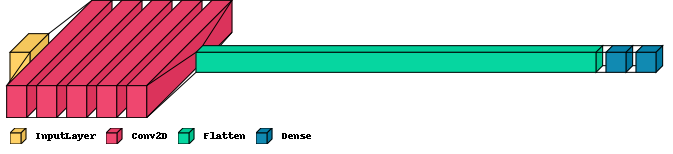

In [7]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model_easy, legend=True)


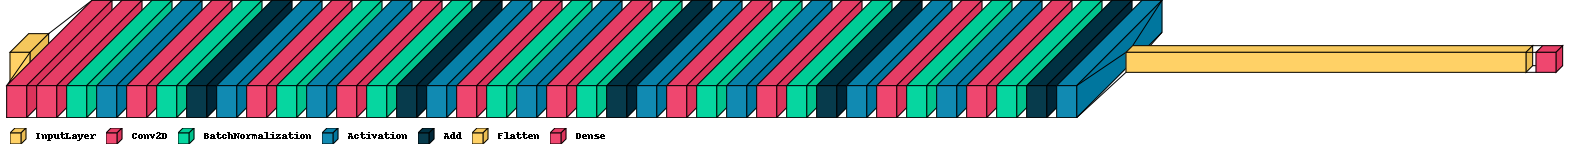

In [8]:
visualkeras.layered_view(model_re, legend=True)

# Training ⬇️

In [9]:
def get_dataset(model_selected):
	model_path_d3 = '../data/random_generated/random_boards_d3.npz'
	model_path_d6 = '../data/random_generated/random_boards_d6.npz'
	model_path_d10 = '../data/random_generated/random_boards_d10.npz'

	model_path = {
		'd3': model_path_d3,
		'd6': model_path_d6,
		'd10': model_path_d10,
	}
	
	container = np.load(model_path[model_selected], allow_pickle=True)
	b, v, f = container['board_matrix'], container['eval'], container['board_fen']
	v[v == None] = 0
	v = np.asarray(v / abs(v).max() / 2 + 0.5, dtype=np.float32) # normalization (0 - 1)
	return b, v


x_train, y_train = get_dataset('d10')
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


## EASY MODEL

In [18]:
model_easy.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model_easy.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 64, 8, 8)          8128      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 8, 8)          36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 8, 8)          36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 8, 8)          36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 8, 8)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0     

In [19]:
x_train, y_train = get_dataset('d3')
model_easy.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

model_easy.save('./engine_models/depth3_model.h5')

Epoch 1/1000
660/660 [==============================] - 16s 24ms/step - loss: 6.0864e-04 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 2/1000
660/660 [==============================] - 15s 23ms/step - loss: 6.2279e-04 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 3/1000
660/660 [==============================] - 15s 23ms/step - loss: 6.2028e-04 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 4/1000
660/660 [==============================] - 15s 23ms/step - loss: 6.2102e-04 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 5/1000
660/660 [==============================] - 15s 23ms/step - loss: 6.1354e-04 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 6/1000
660/660 [==============================] - 16s 24ms/step - loss: 6.1145e-04 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 7/1000
660/660 [==============================] - 15s 23ms/step - loss: 6.0406e-04 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 8/1000
660/660 [==============================] - 17s 26ms/step - loss: 5.9427e-04 - val_loss: 0.0015 - lr: 5.0000e-04


tiempo de ejecucion = 16 mins 20 seg

## MEDIUM MODEL

In [12]:
model_medium.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model_medium.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 8, 8)          8128      
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 8, 8)          36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 8, 8)          36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 8, 8)          36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 8, 8)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0   

In [13]:
x_train, y_train = get_dataset('d6')
model_medium.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

model_medium.save('./engine_models/depth6_model.h5')

Epoch 1/1000
660/660 [==============================] - 19s 28ms/step - loss: 0.0017 - val_loss: 0.0013 - lr: 5.0000e-04
Epoch 2/1000
660/660 [==============================] - 18s 27ms/step - loss: 0.0013 - val_loss: 0.0012 - lr: 5.0000e-04
Epoch 3/1000
660/660 [==============================] - 18s 27ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 5.0000e-04
Epoch 4/1000
660/660 [==============================] - 18s 27ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 5.0000e-04
Epoch 5/1000
660/660 [==============================] - 18s 28ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 5.0000e-04
Epoch 6/1000
660/660 [==============================] - 18s 28ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 5.0000e-04
Epoch 7/1000
660/660 [==============================] - 18s 27ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 5.0000e-04
Epoch 8/1000
660/660 [==============================] - 18s 27ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 5.0000e-04
Epoch 9/1000
660/660 [==========

## HARD MODEL

In [14]:
model_hard.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model_hard.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 8, 8)          8128      
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 8, 8)          36928     
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 8, 8)          36928     
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 8, 8)          36928     
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 8, 8)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0   

In [15]:
x_train, y_train = get_dataset('d10')
model_hard.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

model_hard.save('./engine_models/depth10_model.h5')

Epoch 1/1000
660/660 [==============================] - 16s 24ms/step - loss: 0.0025 - val_loss: 0.0021 - lr: 5.0000e-04
Epoch 2/1000
660/660 [==============================] - 16s 24ms/step - loss: 0.0021 - val_loss: 0.0020 - lr: 5.0000e-04
Epoch 3/1000
660/660 [==============================] - 15s 23ms/step - loss: 0.0020 - val_loss: 0.0020 - lr: 5.0000e-04
Epoch 4/1000
660/660 [==============================] - 14s 22ms/step - loss: 0.0019 - val_loss: 0.0019 - lr: 5.0000e-04
Epoch 5/1000
660/660 [==============================] - 14s 22ms/step - loss: 0.0019 - val_loss: 0.0019 - lr: 5.0000e-04
Epoch 6/1000
660/660 [==============================] - 14s 22ms/step - loss: 0.0019 - val_loss: 0.0020 - lr: 5.0000e-04
Epoch 7/1000
660/660 [==============================] - 14s 22ms/step - loss: 0.0019 - val_loss: 0.0019 - lr: 5.0000e-04
Epoch 8/1000
660/660 [==============================] - 15s 22ms/step - loss: 0.0019 - val_loss: 0.0020 - lr: 5.0000e-04
Epoch 9/1000
660/660 [==========

## RESIDUALS MODEL aka EXTREME

In [20]:
model_re.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model_re.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 14, 8, 8)]   0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 64, 8, 8)     8128        ['input_4[0][0]']                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 8, 8)     36928       ['conv2d_15[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 8, 8)    32          ['conv2d_16[0][0]']              
 alization)                                                                                 

In [21]:
x_train, y_train = get_dataset('d10')
model_re.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

model_re.save('./engine_models/depth10_model_residuals.h5')

Epoch 1/1000
660/660 [==============================] - 54s 79ms/step - loss: 0.0012 - val_loss: 0.0022 - lr: 5.0000e-04
Epoch 2/1000
660/660 [==============================] - 51s 78ms/step - loss: 0.0012 - val_loss: 0.0023 - lr: 5.0000e-04
Epoch 3/1000
660/660 [==============================] - 52s 78ms/step - loss: 0.0012 - val_loss: 0.0022 - lr: 5.0000e-04
Epoch 4/1000
660/660 [==============================] - 52s 79ms/step - loss: 0.0012 - val_loss: 0.0023 - lr: 5.0000e-04
Epoch 5/1000
660/660 [==============================] - 56s 85ms/step - loss: 0.0012 - val_loss: 0.0021 - lr: 5.0000e-04
Epoch 6/1000
660/660 [==============================] - 52s 79ms/step - loss: 0.0012 - val_loss: 0.0023 - lr: 5.0000e-04
Epoch 7/1000
660/660 [==============================] - 58s 88ms/step - loss: 0.0011 - val_loss: 0.0022 - lr: 5.0000e-04
Epoch 8/1000
660/660 [==============================] - 53s 81ms/step - loss: 0.0011 - val_loss: 0.0023 - lr: 5.0000e-04
Epoch 9/1000
660/660 [==========

tiempo de ejecucion = 54 min 30 seg